# Calibration
The purpose of this notebook is to calibrate our data based on peaks, following Matt's work [here (login required)](https://zzz.physics.umn.edu/!cdms/cdms/k100/run_summary/run_76/electron-equivalent_energy_calibration).

In [1]:
#Imports
import sys
import numpy as np              #Will be used for binning
import pandas as pd             #Will be used for data structuring
import lmfit as lf              #Fitting
import matplotlib.pyplot as plt #Basic plotting library
sys.path.append('../')
from R76Tools import *          #Tools written by me for, e.x., importing our files

#Constants
frittspath = "/data/chocula/fritts/data/k100proc/midasrq/byseries/"
baselinecorrections = pd.read_csv("../baselinecorrectionvalues.csv")
gaus_mod = lf.Model(gaus)
gaus_params = gaus_mod.make_params()
gaus_params.add('A',min=0,value=300)
gaus_params.add('sigma',min=0,value=3,max=200)
gaus_params.add('mu',min=100,max=300,value=150)
cal_mod = lf.Model(E_cal)
cal_params = cal_mod.make_params(a=300,c=13)

In [2]:
#User-set Variables
datapath = frittspath
ser = ["07220822_1828","07220826_1219","07220826_1536","07220826_2007","07220827_1153","07220830_1724"]
lab = ["0V","-4V","-21V","-65V","-84V","-84V"]

#Derived variables
_,z = makechain_list(ser,path=datapath,filters=[fittingfilters,"PTOFamps0"],aliases=calibrationaliases)
#Ideally these will pull from the csv file!
for i,x in enumerate(z):
    m = -0.0446154; b = 154
    x["pt_keV_bscorr"] = x["pt_keV"]/(1+m*x["BSel"]/b)
    x["pt0_keV_bscorr"] = x["pt0_keV"]/(1+m*x["BSel"]/b)

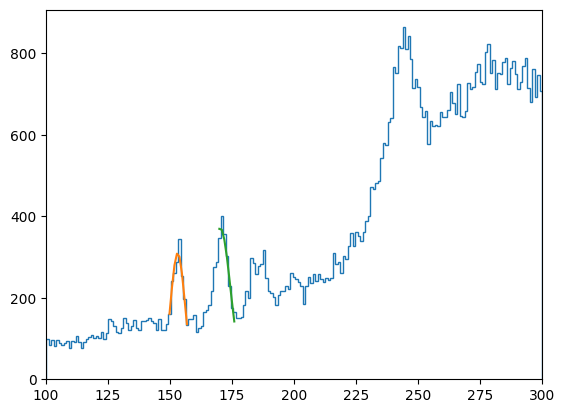

In [3]:
#Initial plotting
bins = np.linspace(100,300,200)
h4ptdat = z[4]["pt_keV_bscorr"][~z[4]["crand"] & z[4]["cbs"]]
h4pt = plt.hist(h4ptdat,bins=bins,histtype="step")

#Lmfit setup
weights = 1/np.sqrt(h4pt[0]) #weights are 1/uncertainty which are Poisson so 1/sqrt(data)
bins = (h4pt[1][:-1] + h4pt[1][1:])/2 #restructure to align for calculations
#fit 1st region
region1 = (bins >= 149) & (bins <= 157)
gaus_params.add('mu',min=100,max=300,value=150)
fit1 = gaus_mod.fit(h4pt[0][region1],gaus_params,x=bins[region1],weights=weights[region1])
#fit 2nd region
region2 = (bins >= 169) & (bins <= 176)
highestregion2 = h4pt[0][region2]==max(h4pt[0][region2])
gaus_params.add('mu',min=169,max=176,value=bins[region2][highestregion2][0])
fit2 = gaus_mod.fit(h4pt[0][region2],gaus_params,x=bins[region2],weights=weights[region2])

#Plot fits
plt.plot(bins[region1],fit1.best_fit)
plt.plot(bins[region2],fit2.best_fit)
plt.xlim(100,300)
plt.show()

In [4]:
fit1

In [5]:
fit2

/tmp/ipykernel_3677770/1347113987.py:11: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(10,30,200)


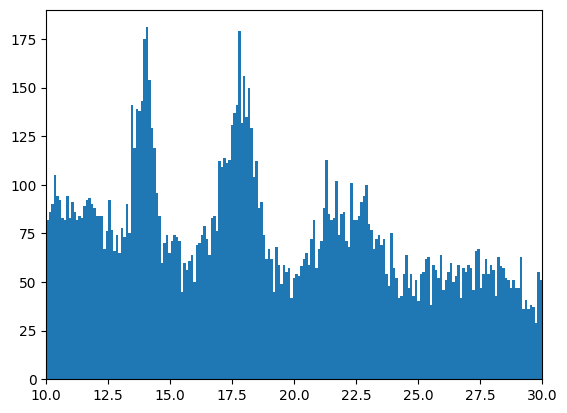

In [6]:
#Calculate our calibration
x = [fit1.best_values['mu'],fit2.best_values['mu']]
y = y_calib
c = y[0]*y[1]*(x[1]-x[0])/(x[0]*y[1]-x[1]*y[0])
a = x[0]*(c/y[0] + 1)
#Apply the result
z[4]["pt_keVee"] = c*z[4]["pt_keV_bscorr"]/(a-z[4]["pt_keV_bscorr"])
z[4]["pt0_keVee"] = c*z[4]["pt0_keV_bscorr"]/(a-z[4]["pt0_keV_bscorr"])
#And plot
h4keVee = plt.hist(z[4]["pt_keVee"][~z[4]["crand"] & z[4]["cbs"]],bins=np.linspace(10,30,200))
plt.xlim(10,30,200)
plt.show()

Emperical: 23.220134908602773
Expected: 23.105263157894736


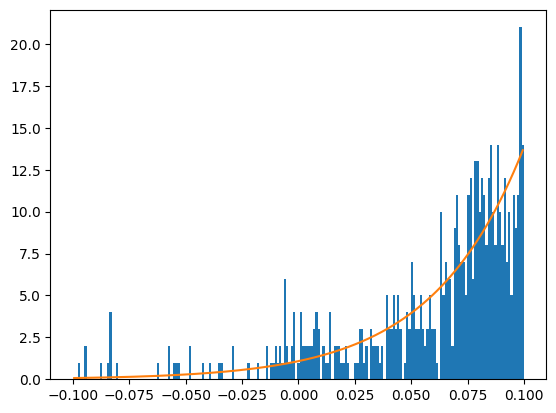

In [7]:
#Diagnostics
g_NTL_empirical = a/c     #Calculated gain from calibration
g_NTL_expected = 1+84/3.8 #1+HV/mean energy to produce one pair for Si
print("Emperical:",g_NTL_empirical)
print("Expected:",g_NTL_expected)

h4n = plt.hist(z[4]["pt0_keVee"][~z[4]["crand"] & z[4]["cbs"]],bins=np.linspace(-0.1,0.1,200))
gaus_params.add('mu',value=0)
bins = (h4n[1][:-1]+h4n[1][1:])/2
fit_NTL = gaus_mod.fit(h4n[0],gaus_params,x=bins)#,weights=1/np.sqrt(h4n[0]))
plt.plot(bins,fit_NTL.best_fit)
plt.show()
fit_NTL

In [8]:
print(a,c)

290.1837509303938 12.497074288008735


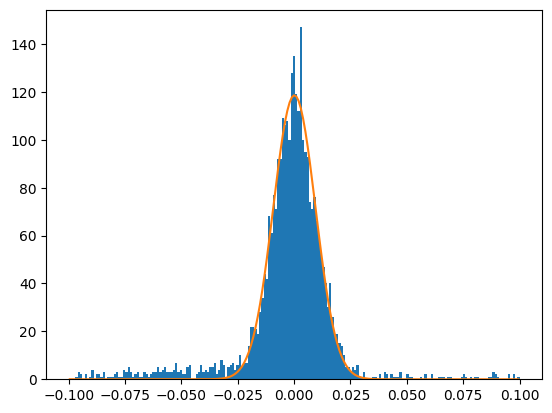

In [23]:
#Debug
z[4]["pt_keVee_root"] = 13.1849*z[4]["pt_keV_bscorr"]/(297.667-z[4]["pt_keV_bscorr"])
z[4]["pt0_keVee_root"] = 13.1849*z[4]["pt0_keV_bscorr"]/(297.667-z[4]["pt0_keV_bscorr"])

h4n = plt.hist(z[4]["pt0_keVee_root"][z[4]["crand"] & z[4]["cbs"]],bins=np.linspace(-0.1,0.1,200))
gaus_params.add('mu',value=0,min=-0.1,max=0.1)
bins = (h4n[1][:-1]+h4n[1][1:])/2
fit_NTL = gaus_mod.fit(h4n[0],gaus_params,x=bins)#,weights=1/np.sqrt(h4n[0]))
plt.plot(bins,fit_NTL.best_fit)
plt.show()
fit_NTL